# 使用国内资产复现bender的论文

In [1]:
import os, sys, argparse, logging

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
from datetime import datetime
from copy import deepcopy
from tqdm import tqdm

this_path = os.path.abspath('.')
if this_path not in sys.path:
    sys.path.append(this_path)

from factor_portfolio import *
from load_data import *
from backtest import *

In [2]:
date_range = [datetime(2018,1,1), datetime(2021,12,31)]

## 1.按步骤分解

In [3]:
# 读入资产数据
asset_data_raw = getAssetData().fillna(method='ffill')
asset_data = asset_data_raw.rolling(22).mean()

# 读入因子数据
factor_data_raw = getFactorData().reindex(asset_data.index).fillna(method='ffill').rolling(22).mean()
factor_data = factor_data_raw.rolling(22).mean()

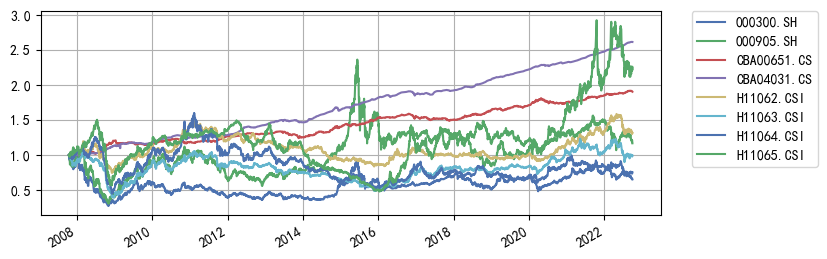

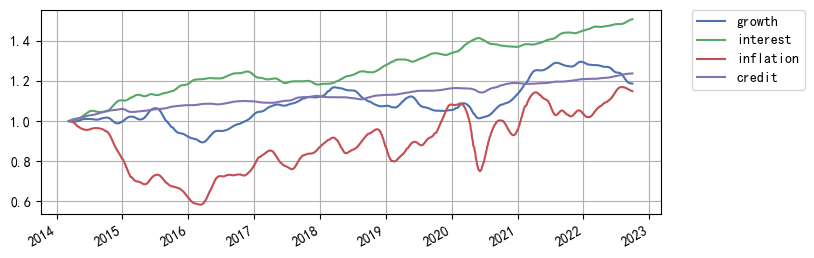

In [4]:
(asset_data_raw.dropna()/asset_data_raw.dropna().iloc[0]).plot(figsize=(8,3), grid=True)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

(factor_data.dropna()/factor_data.dropna().iloc[0]).plot(figsize=(8,3), grid=True)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

In [5]:
id_date = datetime(2019, 3, 31)
look_back = 252*3

tmp_asset_data = asset_data.loc[:id_date].iloc[-look_back:]
tmp_factor_data = factor_data.loc[:id_date].iloc[-look_back:]

asset_returns = tmp_asset_data.pct_change().fillna(0)
factor_returns = tmp_factor_data.pct_change().fillna(0)



### Step 2： Estimating Asset Class Factor Exposures

In [6]:
exposure = getFatorExposureFrame(asset_returns, factor_returns)
exposure

,growth,interest,inflation,credit
000300.SH,0.930664,-0.659634,-0.696464,0.862968
000905.SH,1.637431,0.237341,-0.132209,0.918660
CBA00651.CS,-0.319662,1.432393,-1.463571,-1.538925
CBA04031.CS,-1.370486,1.391461,-0.877398,0.072313
H11062.CSI,0.027646,-0.884551,1.414748,-0.927145
H11063.CSI,-0.183142,-0.635063,0.042614,-0.044895
H11064.CSI,-1.128361,-1.128719,0.614984,-0.661533
H11065.CSI,0.405910,0.246772,1.097296,1.318556


### Step 3: Constructing Factor-Mimicking Portfolios

In [7]:
fmp = getFactorMimickingPortfolio(asset_returns, factor_returns)
fmp

,growth,interest,inflation,credit,intercept
000300.SH,0.016832,-0.491949,-0.432001,0.156240,0.316245
000905.SH,0.173090,0.327630,0.248606,0.022032,-0.006310
CBA00651.CS,0.214961,0.084291,-0.236086,-0.392637,-0.004782
CBA04031.CS,-0.370319,0.182782,0.138286,0.333731,0.339121
H11062.CSI,0.053245,-0.024350,0.355496,-0.091179,0.431215
H11063.CSI,0.054993,-0.037030,-0.052589,0.071128,0.091424
H11064.CSI,-0.214221,-0.136545,-0.064120,-0.134422,-0.164131
H11065.CSI,0.071421,0.095170,0.042408,0.035107,-0.002783


In [8]:
# fmp回测表现
class FmpStrategy(Strategy):
    def __init__(self, factor_data=None, factor_name=None, scale=1):
        super().__init__()
        self._factor_data = factor_data
        self._factor_name = factor_name
        self._scale = scale

    def run(self, id_date, asset_data):
        asset_data = asset_data.rolling(22).mean().dropna()
        tmp_asset_returns = asset_data.pct_change().fillna(0)
        tmp_factor_data = self._factor_data.reindex(asset_data.index)
        tmp_factor_returns = tmp_factor_data.pct_change().fillna(0)

        return getFactorMimickingPortfolio(tmp_asset_returns, tmp_factor_returns, scale=self._scale)[self._factor_name]
      

In [9]:
fmp_value = pd.DataFrame()
fmp_weights = {}

for factor in ['intercept']+list(factor_data.columns):
    fmp_backtest = BacktestManager(
        FmpStrategy(factor_data=factor_data, factor_name=factor, scale=None), 
        asset_data_raw, 
        date_range = date_range, 
        frequency = 22, 
        look_back = 252*3, 
    )
    fmp_backtest.run()
    fmp_value[factor] = fmp_backtest.getHistoricalValue()
    weights_dict = fmp_backtest._historcial_weights
    fmp_weights[factor] = pd.DataFrame(columns=asset_data.columns)
    for id_date, weights in weights_dict.items():
        fmp_weights[factor].loc[id_date] = weights.reindex(fmp_weights[factor].columns)



100%|██████████| 973/973 [00:06<00:00, 161.84it/s]


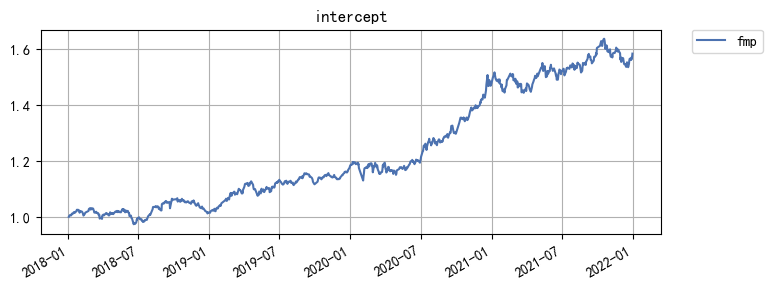

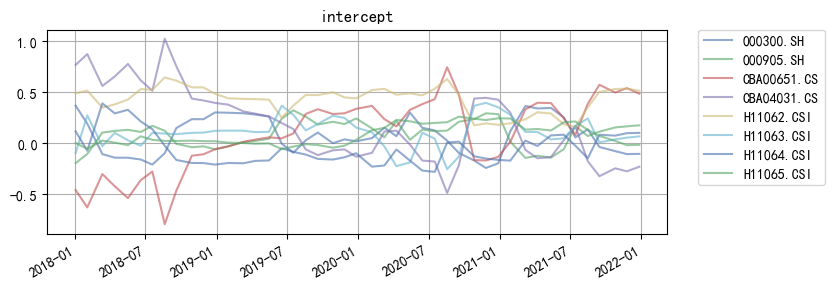

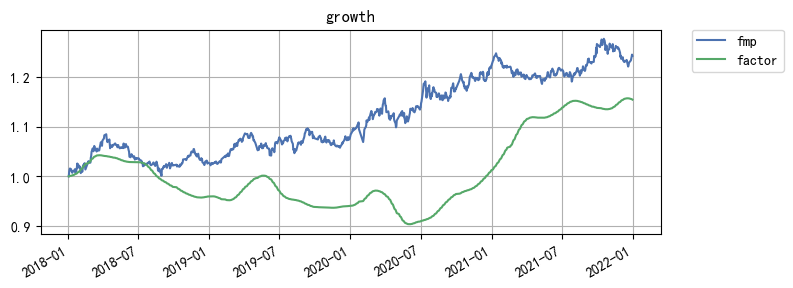

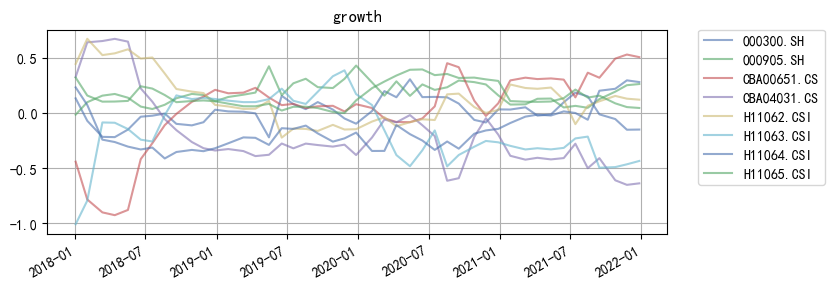

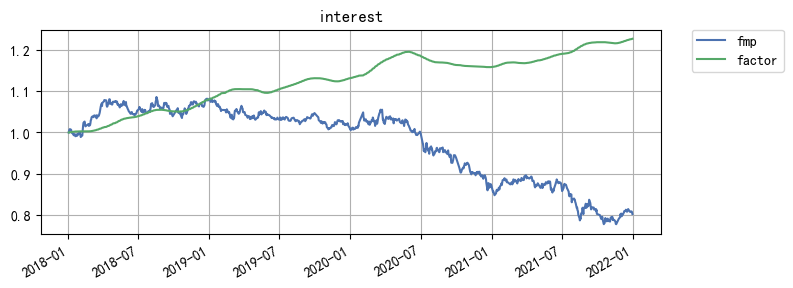

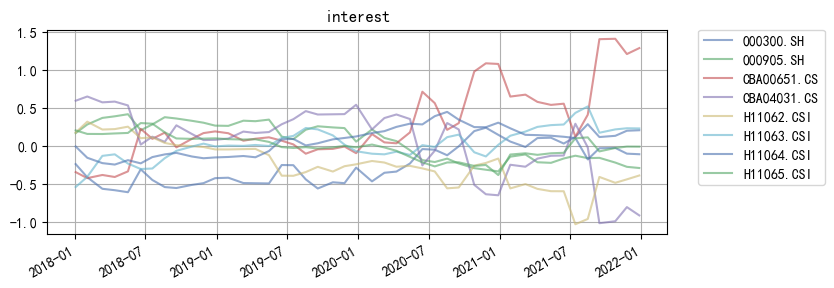

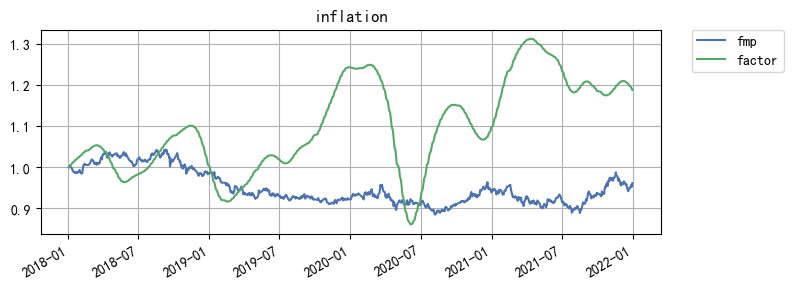

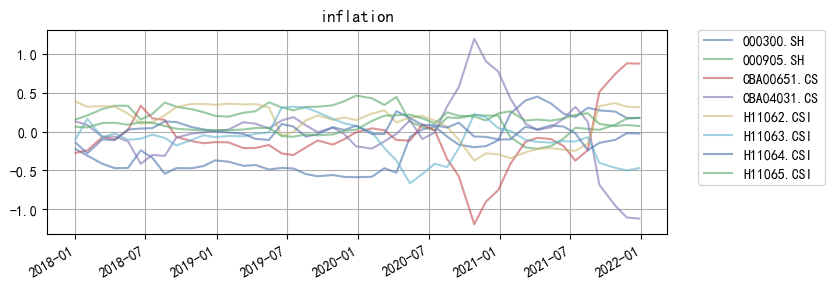

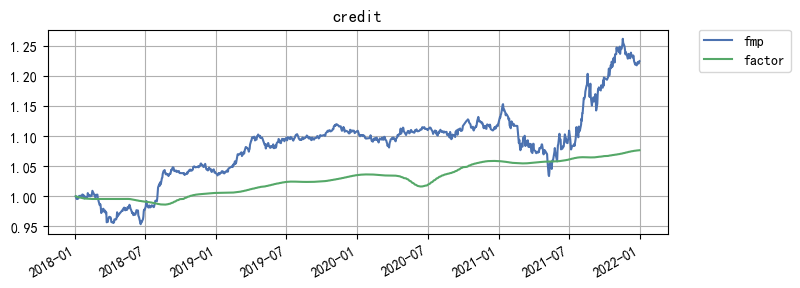

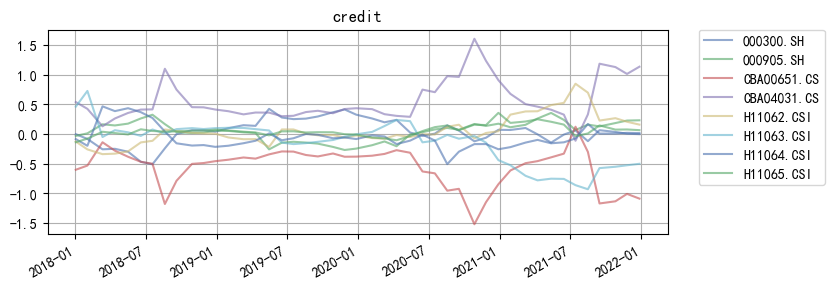

In [10]:
tmp_factor_data = factor_data.reindex(fmp_value.index)
tmp_factor_data /= tmp_factor_data.iloc[0]
fmp_value /= fmp_value.iloc[0]

for factor in ['intercept']+list(factor_data.columns):
    df = pd.DataFrame()
    df['fmp'] = fmp_value[factor]
    if factor != 'intercept':
        df['factor'] = tmp_factor_data[factor]
    df.plot(figsize=(8,3), grid=True, title=factor)
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

    fmp_weights[factor].plot(figsize=(8,3), grid=True, title=factor, alpha=0.6)
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)



### Step 4: Forecasting Factor-Mimicking Portfolio Return

In [11]:
# 使用历史收益率作为fmp收益率预测
fmp_lookback = 252 * 1
tmp_fmp_returns = fmp_value.loc[:id_date].iloc[-fmp_lookback:].pct_change().fillna(0)


### Step 5: Constructing the Optimal Factor Portfolio

In [18]:
def optimalFactorPortfolio(fmp_return):
    cov = np.matrix(fmp_return.cov()).astype('float64') * 252
    w0 = [1/fmp_return.shape[1]] * fmp_return.shape[1]
    Q = np.matrix((1+fmp_return).cumprod().iloc[-1]-1).astype('float64').T

    def factorPortfolioReturn(w,cov,Q): 
        w = np.matrix(w).astype('float64').T
        # print(w.T @ Q, 0.5 * w.T @ cov @ w)
        return -(w.T @ Q - 0.5 * w.T @ cov @ w)[0,0]
    
    #set constraints
    cons = [] 
    cons.append({'type': 'eq', 'fun': lambda w: sum(w)-1})
    bounds = tuple([(-1e3,1e3)] * fmp_return.shape[1])

    factor_weights = minimize(factorPortfolioReturn, w0, constraints=cons, args=(cov, Q), bounds=bounds,  method='SLSQP').x
    return pd.DataFrame(factor_weights, index=fmp_return.columns).T

In [19]:
opt_fmp_weights = optimalFactorPortfolio(tmp_fmp_returns)
opt_fmp_weights

,intercept,growth,interest,inflation,credit
0,12.702435,-19.937691,-0.492777,-7.028308,15.75634


### Step 6: Inferring Expected Returns for Asset Classes

In [14]:
def getAssetExpectedReturns(fmp_weights, factor_weights, asset_returns):
    asset_weights = np.matrix(factor_weights).dot(np.matrix(fmp_weights).T)
    cov = np.matrix(asset_returns.cov()).astype('float64') * 252
    alpha = cov @ asset_weights
    return pd.DataFrame(alpha,index=asset_returns.columns).T

In [15]:
tmp_asset_returns = asset_data_raw.pct_change().loc[:id_date].iloc[-252:]
alpha = getAssetExpectedReturns(opt_fmp_weights, fmp, tmp_asset_returns)
alpha

,000300.SH,000905.SH,CBA00651.CS,CBA04031.CS,H11062.CSI,H11063.CSI,H11064.CSI,H11065.CSI
0,0.388,0.193086,0.000896,0.000615,0.156839,0.14966,0.120288,0.103


In [32]:
class AssetAlphaStrategy(Strategy):
    def __init__(self, fmp_value):
        super().__init__()
        self._asset_alpha = pd.DataFrame(columns=list(asset_data.columns))
        self._opt_fp_df = pd.DataFrame(columns=list(fmp_value))
        self._fmp_returns = fmp_value.pct_change()

    def run(self, id_date, asset_data):
        opt_fp = optimalFactorPortfolio(self._fmp_returns.loc[:id_date].iloc[-fmp_lookback:])
        print(self._fmp_returns.loc[:id_date].iloc[-fmp_lookback:])
        sys.exit(1)
        self._opt_fp_df.loc[id_date] = list(opt_fp.values[0])
        tmp_fmp_weights = pd.DataFrame({factor: v.loc[id_date].reindex(list(asset_data.columns)) for factor,v in fmp_weights.items()})
        tmp_asset_returns = asset_data_raw.pct_change().loc[:id_date].iloc[-fmp_lookback:]
        self._asset_alpha.loc[id_date] = list(getAssetExpectedReturns(opt_fp, tmp_fmp_weights, tmp_asset_returns).values[0])
        return pd.Series([0]*asset_data.shape[1], index=asset_data.columns)
        

In [33]:
date_range = [datetime(2018,1,1), datetime(2021,12,31)]
aa_backtest = BacktestManager(
    AssetAlphaStrategy(fmp_value), 
    asset_data_raw, 
    date_range = date_range, 
    frequency = 22, 
    look_back = 252, 
)
aa_backtest.run()

  0%|          | 0/973 [00:00<?, ?it/s]

            intercept  growth  interest  inflation  credit
2018-01-02        NaN     NaN       NaN        NaN     NaN


SystemExit: 1

c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\IPython\core\interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [29]:
aa_backtest._strategy._asset_alpha

,000300.SH,000905.SH,CBA00651.CS,CBA04031.CS,H11062.CSI,H11063.CSI,H11064.CSI,H11065.CSI
2018-01-02,0.000459,0.000771,-0.000326,0.000017,0.002046,-0.001650,0.000912,0.003028
2018-02-01,-0.069189,0.071292,0.011909,0.011819,0.062754,-0.178509,-0.196797,-0.105456
2018-03-12,-0.136914,0.452203,0.039513,0.018205,0.176528,0.510960,0.945413,1.080343
2018-04-13,-0.126145,0.183541,0.012487,0.008351,0.070011,0.158814,0.216421,0.360788
2018-05-17,-0.210284,0.207321,0.008950,0.009142,0.133083,0.006773,0.110459,0.256768
2018-06-19,-0.090791,-0.021786,0.007058,0.003638,0.015381,-0.121190,-0.133765,0.105051
2018-07-19,-0.193711,0.019173,0.013593,0.002818,0.053157,-0.037801,0.013653,0.261067
2018-08-20,-0.205403,-0.002738,0.007771,0.005745,0.036065,-0.039731,0.007064,0.119445
2018-09-19,-0.019242,-0.045078,0.000293,0.004296,-0.063458,0.017688,-0.156119,-0.005430
2018-10-29,0.335737,0.118375,0.016137,0.002325,-0.257986,0.081095,-0.204049,0.033206


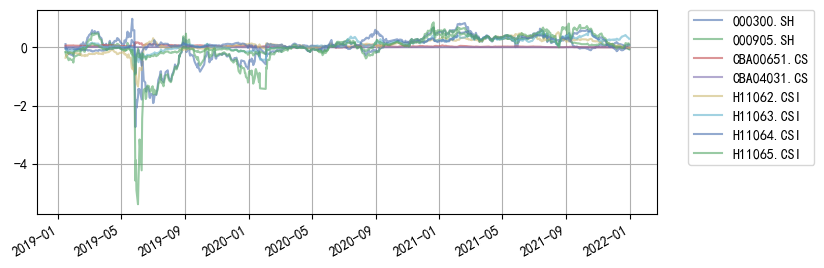

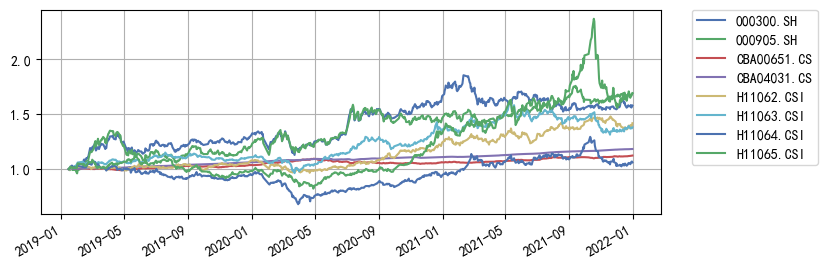

In [ ]:
asset_alpha.plot(figsize=(8,3), grid=True, alpha=0.6)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

tmp = asset_data_raw.reindex(asset_alpha.index)
(tmp/tmp.iloc[0]).reindex(asset_alpha.index).plot(figsize=(8,3), grid=True)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)